This tutorials is made using references from : 
* https://github.com/PatWalters/practical_cheminformatics_tutorials
* https://doc.datamol.io/stable/tutorials/Clustering.html
* https://greglandrum.github.io/rdkit-blog/similarity/tutorial/2020/11/18/sphere-exclusion-clustering.html

In [1]:
import os 
import sys
import pandas as pd
import numpy as np
import operator

In [2]:
from rdkit import Chem
from rdkit import DataStructs

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
IPythonConsole.ipython_useSVG=True  #SVG's tend to look nicer than the png counterparts

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors
import time
rdDepictor.SetPreferCoordGen(True)
import rdkit
%matplotlib inline
print(rdkit.__version__)

2022.03.5


In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# High DPI rendering for mac
%config InlineBackend.figure_format = 'retina'

# "Infinite" DPI vector output -- overkill 
%config InlineBackend.figure_format = 'svg'
 
# Plot matplotlib plots with white background: 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

In [4]:
# clustering specific imports from Rdkit 
from rdkit.Chem import DataStructs 
from rdkit.ML.Cluster import Butina
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [5]:
x = pd.read_csv('./data/small_molecule_data/tox21.csv')

In [6]:
x.sample(5)

,smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
439,CC(Cl)(Cl)C(=O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5205,Nc1ccc([As](=O)(O)O)cc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7260,CCCCOC(=O)CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2195,COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(C)cc(C)n1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5563,Cc1ccc(C)c(OCCCC(C)(C)C(=O)O)c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
mol_obj = [Chem.MolFromSmiles(smi, sanitize=True) for smi in list(x['smiles'])]
len(mol_obj)

[16:41:47] WARNING: not removing hydrogen atom without neighbors


7831

**Generate fingerprints for the molecules - using Morgan FP2**

In [10]:
from rdkit.Chem import rdMolDescriptors
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_obj]

**Calculate distance matrix for the molecules**

In [11]:
dists  = [] 
n_fps = len(fps)
for i in range(1, n_fps):
    sim = DataStructs.cDataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    dists.extend([ 1-x for x in sim ])

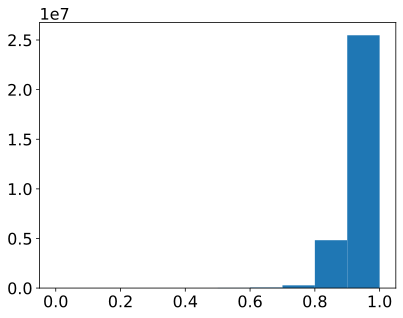

In [12]:
plt.hist(dists);

**Clustering the molecules based on the FPs and  the distance matrix**

In [46]:
cutoff_distance = 0.35 # Any molecules closer than this are kept in one cluster so <= cutoff_distance
mol_clusters = Butina.ClusterData(dists, n_fps, distThresh=cutoff_distance, isDistData=True)
cluster_id_list = [0]*n_fps

for idx, cluster in enumerate(mol_clusters, 1):
    for member in cluster:
        cluster_id_list[member] = idx

In [47]:
# Add the cluster_id to the dataframe 
x['cluster'] = cluster_id_list

In [48]:
x['cluster'].value_counts(sort=True, ascending=False)

2       21
1       21
3       15
5       13
4       13
        ..
4643     1
4644     1
4645     1
4646     1
689      1
Name: cluster, Length: 6675, dtype: int64

**Calculate intra cluster similarity for the molecules**

In [49]:
x_42 = x.loc[ x['cluster'] ==  1]

In [50]:
x_42.shape

(21, 14)

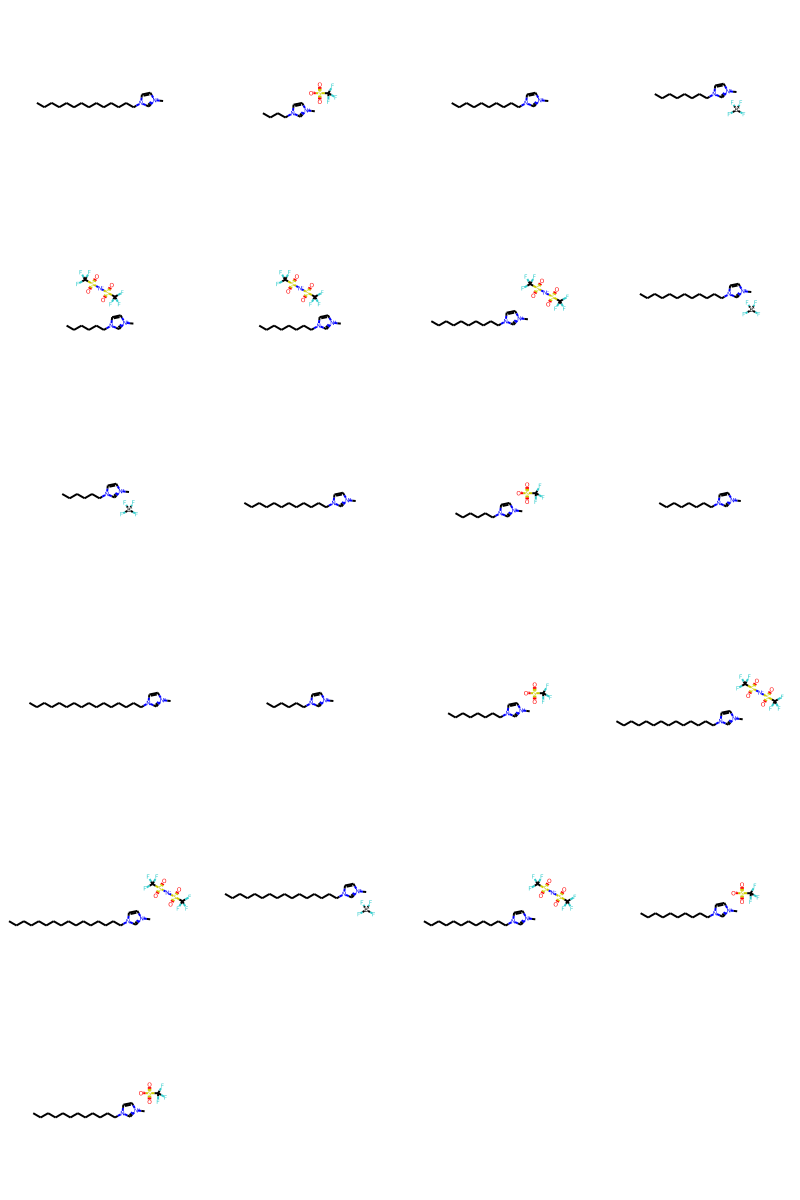

In [51]:
Draw.MolsToGridImage( [mol_obj[x] for x in x_42.index], subImgSize=(200, 200), molsPerRow=4)

In [52]:
# intra-cluster similarity 
res = []
cfps = [ fps[i] for i in x_42.index ]
for i in range(1, x_42.shape[0]):
    sim = DataStructs.cDataStructs.BulkTanimotoSimilarity(cfps[i], cfps[:i])
    res.extend( [1-x for x in sim] )

(array([26.,  8., 24.,  0., 40., 14., 58., 16., 14., 10.]),
 array([0.        , 0.04901961, 0.09803922, 0.14705882, 0.19607843,
        0.24509804, 0.29411765, 0.34313725, 0.39215686, 0.44117647,
        0.49019608]),
 <BarContainer object of 10 artists>)

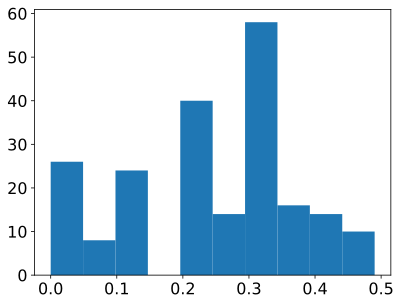

In [53]:
plt.hist(res)

## Pick the most diverse molecules from the cluster 

Implementation of Sphere exclusion algorithm (also called Leader) from Roger Sayles.

In [54]:
from rdkit.SimDivFilters import rdSimDivPickers
lp = rdSimDivPickers.LeaderPicker()

In [55]:
threshold = 0.65 # <- minimum distance between clusters 
picks = lp.LazyBitVectorPick(fps, len(fps), threshold)
len(picks)

3291